# Comparison of Segger vs. 10X for Contamination

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from requirements import *
from segger.data.parquet._utils import (
    read_parquet_region,
    filter_transcripts,
    filter_boundaries,
    load_settings,
    get_polygons_from_xy,
)
from segger.training.segger_data_module import SeggerDataModule
from segger.prediction.predict import load_model, get_similarity_scores
from segger.data.parquet._ndtree import NDTree
from sg_utils.tl.xenium_utils import anndata_from_transcripts
from sg_utils.pp.preprocess_rapids import *
from sg_utils.pl.plot_embedding import plot_embedding
from sg_utils.pl.utils import lighten_color
from matplotlib.colors import LinearSegmentedColormap, to_rgba, to_hex
from sg_utils.pl.plot_segmentation_comparison import *
from sg_utils.tl.generate_boundaries import generate_boundaries
import celltypist as ct
from pydeseq2.dds import DeseqDataSet
from pydeseq2.default_inference import DefaultInference
from pydeseq2.ds import DeseqStats
from adjustText import adjust_text
from scipy.cluster.hierarchy import linkage, dendrogram
import torch

In [3]:
from segger.data.utils import (
    get_edge_index,
    coo_to_dense_adj,
    create_anndata,
    format_time
)

## Callouts

### Main

In [3]:
# Region to plot
xmin, ymin, xmax, ymax = 960, 12050, 1140, 12230
region = shapely.box(xmin, ymin, xmax, ymax)

In [4]:
# Read and filter membrane/DAPI image
image_filepath = data_dir / 'segmentation_image.npy'
image = np.load(image_filepath)
mpp = 0.2125 * 2
image = image[
    int(ymin / mpp): int(ymax / mpp),
    int(xmin / mpp): int(xmax / mpp),
]
mem = np.tile(image[:, :, 1, np.newaxis], (1, 1, 3)) * np.array([0, 1, 1])
nuc = np.tile(image[:, :, 0, np.newaxis], (1, 1, 3)) * np.array([1, 0, 0])
image = (mem + nuc).astype('uint8')

In [27]:
# Read and filter transcripts
transcripts_filepath = data_dir / 'labeled_transcripts_v2.parquet'
xe_settings = load_settings('xenium')
transcripts = read_parquet_region(
    transcripts_filepath,
    *xe_settings.transcripts.xy,
    bounds=region,
    extra_columns=['cellpose_cell_id', 'feature_name', 'cellpose_cell_type'],
)

# Read and filter boundary polygons
bd_cellpose_filepath = data_dir / 'cellpose_mask_polygons.parquet'
bd_cellpose = gpd.read_parquet(bd_cellpose_filepath)
mask = bd_cellpose.within(region.buffer(20))
bd_cellpose = bd_cellpose[mask]

# Filter boundaries to epithelial
is_epi = transcripts['cellpose_cell_type'].eq('Epithelial/Cancer')
gb = is_epi.groupby(transcripts['cellpose_cell_id'])
mask = gb.mean().gt(0.33)
mask &= gb.size().gt(1)
mask = bd_cellpose.index.isin(mask.index[mask])
bd_cellpose = bd_cellpose[mask]

# Smooth pixelated outlines
bd_cellpose = bd_cellpose.buffer(2).buffer(-2)

#### Markers per Cell Type

In [12]:
# Read in CellTypist model
ct_model = ct.Model.load(str(data_dir / 'NSCLC_celltypist_model.pkl'))

# Get top markers used for classification
coefs = pd.DataFrame(
    ct_model.classifier.coef_.T,
    index=ct_model.features,
    columns=ct_model.cell_types,
)

#### Segger

In [60]:
# Segger
seg_col = 'segger_cell_id_HDE46PBXJB'
score_col = seg_col.replace('cell_id', 'score')

# Read and filter transcripts
transcripts_filepath = data_dir / 'labeled_transcripts.parquet'
xe_settings = load_settings('xenium')
transcripts = read_parquet_region(
    transcripts_filepath,
    *xe_settings.transcripts.xy,
    bounds=region,
    extra_columns=[seg_col, score_col, 'feature_name', 'cellpose_cell_type'],
    extra_filters=[
        (score_col, '>', 0.),
    ],
)

# Filter boundaries to epithelial
is_epi = transcripts['cellpose_cell_type'].eq('Epithelial/Cancer')
gb = is_epi.groupby(transcripts[seg_col])
mask = gb.mean().gt(0.33)
mask &= gb.size().gt(10)
mask = transcripts[seg_col].isin(mask.index[mask])
transcripts = transcripts[mask]

# Colors for transcripts
colors = transcripts['feature_name'].map(
    coefs.idxmax(1).map(named_colors)
)
is_epi = transcripts['cellpose_cell_type'].eq('Epithelial/Cancer')
colors[is_epi] = to_hex(lighten_color(named_colors['Epithelial/Cancer'], 1.25))
colors[~is_epi] = 'tab:orange'

In [61]:
# Generate boundaries
bd = generate_boundaries(
    transcripts,
    x='x_location',
    y='y_location',
    cell_id=seg_col,
).set_index('cell_id')

# Smooth boundaries
bd = bd.simplify(0.1)
bd = bd.buffer(2).buffer(-2).buffer(-1).buffer(1)

100%|██████████| 115/115 [00:04<00:00, 28.31it/s]


(960.0, 1140.0, 12050.0, 12230.0)

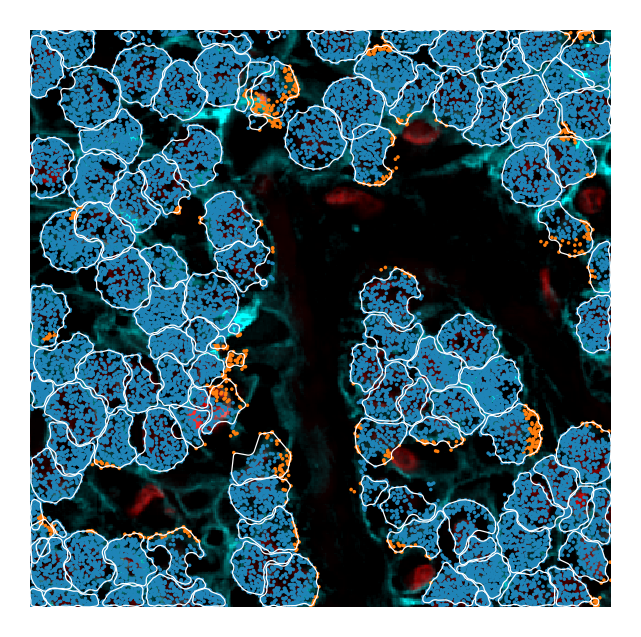

In [62]:
fig, ax = plt.subplots(1,1, figsize=(2.5, 2.5))

styles = dict(linewidths=0.3, facecolors=[0]*4, edgecolors='w', zorder=2)
plot_segmentation_boundaries(bd, ax=ax, **styles)

styles = dict(s=0.75, lw=0, legend=False, zorder=1, c=colors, rasterized=True)
sns.scatterplot(transcripts, x='x_location', y='y_location', ax=ax, **styles)

format_ax(ax, region)
ax.axis('off')

fig.savefig(media_dir / f'contamination_{seg_col}.svg')
plt.close()

#### 10X

In [43]:
# Segger
seg_col = '10x_cell_id'

# Read and filter transcripts
transcripts_filepath = data_dir / 'labeled_transcripts.parquet'
xe_settings = load_settings('xenium')
transcripts = read_parquet_region(
    transcripts_filepath,
    *xe_settings.transcripts.xy,
    bounds=region,
    extra_columns=[seg_col, 'feature_name', 'cellpose_cell_type'],
)

# Filter boundaries to epithelial
is_epi = transcripts['cellpose_cell_type'].eq('Epithelial/Cancer')
gb = is_epi.groupby(transcripts[seg_col])
mask = gb.mean().gt(0.33)
mask &= gb.size().gt(10)
mask = transcripts[seg_col].isin(mask.index[mask])
transcripts = transcripts[mask]

colors = transcripts['feature_name'].map(coefs.idxmax(1).map(named_colors))
is_epi = transcripts['cellpose_cell_type'].eq('Epithelial/Cancer')
colors[is_epi] = to_hex(lighten_color(named_colors['Epithelial/Cancer'], 1.25))
colors[~is_epi] = 'tab:orange'

In [44]:
boundaries_filepath = data_dir / '10x_cell_boundaries.parquet'
xe_settings = load_settings('xenium')
inset = region.buffer(20)
outset = region.buffer(40)
boundaries = read_parquet_region(
    boundaries_filepath,
    *xe_settings.boundaries.xy,
    bounds=outset,
    extra_columns=[xe_settings.boundaries.label],
)
boundaries = filter_boundaries(
    boundaries,
    inset,
    outset,
    *xe_settings.boundaries.xy,
    xe_settings.boundaries.label,
)
bd = get_polygons_from_xy(
    boundaries,
    *xe_settings.boundaries.xy,
    xe_settings.boundaries.label,
)
bd = bd[bd.index.isin(transcripts['10x_cell_id'].unique())]

100%|██████████| 114/114 [00:00<00:00, 3698.82it/s]


(960.0, 1140.0, 12050.0, 12230.0)

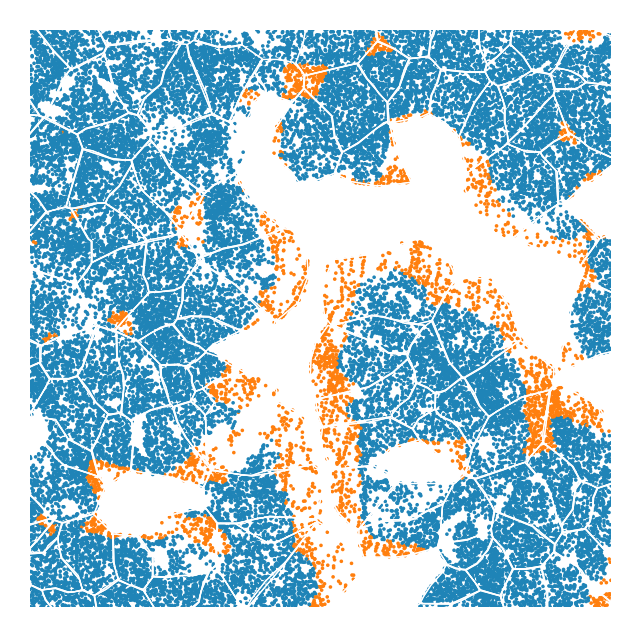

In [45]:
fig, ax = plt.subplots(1,1, figsize=(2.5, 2.5))

styles = dict(linewidths=0.3, facecolors=[0]*4, edgecolors='w', zorder=2)
plot_segmentation_boundaries(bd, ax=ax, **styles)

for b in tqdm(bd):
    coords = np.array(b.exterior.xy)
    coords = np.concatenate((coords, coords[:, :1]), axis=1)
    ax.plot(coords[0], coords[1], lw=0.3, c='w', zorder=2)

styles = dict(s=0.75, lw=0, legend=False, zorder=1, c=colors, rasterized=True)
sns.scatterplot(transcripts, x='x_location', y='y_location', ax=ax, **styles)

format_ax(ax, region)
ax.axis('off')

fig.savefig(media_dir / f'contamination_{seg_col}.svg')
plt.close()

In [79]:
# Plot IF images
fig, ax = plt.subplots(1,1, figsize=(2.5, 2.5))

plot_segmentation_comparison(
    bd_cellpose,
    bd_cellpose,
    bd_true_kwargs=dict(alpha=0.),
    bd_pred_kwargs=dict(linewidths=0.25, facecolors=[0]*4),
    ax=ax,
    region=region,
    img=None,
    show_outlines=True,
)
ax.axis('off')  # remove ticks
ax.set_facecolor([0]*4)

fig.savefig(media_dir / f'contamination_cellpose_cell_id_outlines.svg')
plt.close()

In [72]:
# Plot IF images
fig, ax = plt.subplots(1,1, figsize=(2.5, 2.5))
plot_image(
    image=image,
    ax=ax,
    region=region,
)
ax.axis('off')  # remove ticks

fig.savefig(media_dir / f'contamination_if_underlay.png', dpi=600)
plt.close()

### Supplementary

In [18]:
# Region to plot
i = 1
save = True
regions = [
    (5213, 10194, 5393, 10374),
    (883, 9554, 1063, 9734)
]
xmin, ymin, xmax, ymax = regions[i]
region = shapely.box(xmin, ymin, xmax, ymax)
suffix = f'supp_{i+1}'

In [21]:
# Read and filter membrane/DAPI image
image_filepath = data_dir / 'segmentation_image.npy'
image = np.load(image_filepath)
mpp = 0.2125 * 2
image = image[
    int(ymin / mpp): int(ymax / mpp),
    int(xmin / mpp): int(xmax / mpp),
]
mem = np.tile(image[:, :, 1, np.newaxis], (1, 1, 3)) * np.array([0, 1, 1])
nuc = np.tile(image[:, :, 0, np.newaxis], (1, 1, 3)) * np.array([1, 0, 0])
image = (mem + nuc).astype('uint8')

In [22]:
# Read and filter transcripts
transcripts_filepath = data_dir / 'labeled_transcripts_v2.parquet'
xe_settings = load_settings('xenium')
transcripts = read_parquet_region(
    transcripts_filepath,
    *xe_settings.transcripts.xy,
    bounds=region,
    extra_columns=['cellpose_cell_id', 'feature_name', 'cellpose_cell_type'],
)

# Read and filter boundary polygons
bd_cellpose_filepath = data_dir / 'cellpose_mask_polygons.parquet'
bd_cellpose = gpd.read_parquet(bd_cellpose_filepath)
mask = bd_cellpose.within(region.buffer(20))
bd_cellpose = bd_cellpose[mask]

# Filter boundaries to epithelial
is_epi = transcripts['cellpose_cell_type'].eq('Epithelial/Cancer')
gb = is_epi.groupby(transcripts['cellpose_cell_id'])
mask = gb.mean().gt(0.33)
mask &= gb.size().gt(1)
mask = bd_cellpose.index.isin(mask.index[mask])
bd_cellpose = bd_cellpose[mask]

# Smooth pixelated outlines
bd_cellpose = bd_cellpose.buffer(2).buffer(-2)

#### Segger

In [23]:
# Segger
seg_col = 'segger_cell_id_HDE46PBXJB'
score_col = seg_col.replace('cell_id', 'score')

# Read and filter transcripts
transcripts_filepath = data_dir / 'labeled_transcripts.parquet'
xe_settings = load_settings('xenium')
transcripts = read_parquet_region(
    transcripts_filepath,
    *xe_settings.transcripts.xy,
    bounds=region,
    extra_columns=[seg_col, score_col, 'feature_name', 'cellpose_cell_type'],
    extra_filters=[
        (score_col, '>', 0.),
    ],
)

# Filter boundaries to epithelial
is_epi = transcripts['cellpose_cell_type'].eq('Epithelial/Cancer')
gb = is_epi.groupby(transcripts[seg_col])
mask = gb.mean().gt(0.33)
mask &= gb.size().gt(10)
mask = transcripts[seg_col].isin(mask.index[mask])
transcripts = transcripts[mask]

# Colors for transcripts
colors = transcripts['feature_name'].copy()
is_epi = transcripts['cellpose_cell_type'].eq('Epithelial/Cancer')
colors[is_epi] = to_hex(lighten_color(named_colors['Epithelial/Cancer'], 1.25))
colors[~is_epi] = 'tab:orange'

In [24]:
# Generate boundaries
bd = generate_boundaries(
    transcripts,
    x='x_location',
    y='y_location',
    cell_id=seg_col,
).set_index('cell_id')

# Smooth boundaries
bd = bd.simplify(0.1)
bd = bd.buffer(2).buffer(-2).buffer(-1).buffer(1)

100%|██████████| 143/143 [00:05<00:00, 25.07it/s]


In [25]:
fig, ax = plt.subplots(1,1, figsize=(2.5, 2.5))

styles = dict(linewidths=0.3, facecolors=[0]*4, edgecolors='w', zorder=2)
plot_segmentation_boundaries(bd, ax=ax, **styles)

if not save:
    plot_image(
        image=image,
        ax=ax,
        region=region,
    )

styles = dict(s=0.75, lw=0, legend=False, zorder=1, c=colors, rasterized=True)
sns.scatterplot(transcripts, x='x_location', y='y_location', ax=ax, **styles)

format_ax(ax, region)
ax.axis('off')

if save:
    fig.savefig(media_dir / f'contamination_{seg_col}_{suffix}.svg')
    plt.close()

#### 10X

In [26]:
# Segger
seg_col = '10x_cell_id'

# Read and filter transcripts
transcripts_filepath = data_dir / 'labeled_transcripts.parquet'
xe_settings = load_settings('xenium')
transcripts = read_parquet_region(
    transcripts_filepath,
    *xe_settings.transcripts.xy,
    bounds=region,
    extra_columns=[seg_col, 'feature_name', 'cellpose_cell_type'],
)

# Filter boundaries to epithelial
is_epi = transcripts['cellpose_cell_type'].eq('Epithelial/Cancer')
gb = is_epi.groupby(transcripts[seg_col])
mask = gb.mean().gt(0.33)
mask &= gb.size().gt(10)
mask = transcripts[seg_col].isin(mask.index[mask])
transcripts = transcripts[mask]

colors = transcripts['feature_name'].copy()
is_epi = transcripts['cellpose_cell_type'].eq('Epithelial/Cancer')
colors[is_epi] = to_hex(lighten_color(named_colors['Epithelial/Cancer'], 1.25))
colors[~is_epi] = 'tab:orange'

In [27]:
boundaries_filepath = data_dir / '10x_cell_boundaries.parquet'
xe_settings = load_settings('xenium')
inset = region.buffer(20)
outset = region.buffer(40)
boundaries = read_parquet_region(
    boundaries_filepath,
    *xe_settings.boundaries.xy,
    bounds=outset,
    extra_columns=[xe_settings.boundaries.label],
)
boundaries = filter_boundaries(
    boundaries,
    inset,
    outset,
    *xe_settings.boundaries.xy,
    xe_settings.boundaries.label,
)
bd = get_polygons_from_xy(
    boundaries,
    *xe_settings.boundaries.xy,
    xe_settings.boundaries.label,
)
bd = bd[bd.index.isin(transcripts['10x_cell_id'].unique())]

In [28]:
fig, ax = plt.subplots(1,1, figsize=(2.5, 2.5))

styles = dict(linewidths=0.3, facecolors=[0]*4, edgecolors='w', zorder=2)
plot_segmentation_boundaries(bd, ax=ax, **styles)

if not save:
    plot_image(
        image=image,
        ax=ax,
        region=region,
    )

for b in tqdm(bd):
    coords = np.array(b.exterior.xy)
    coords = np.concatenate((coords, coords[:, :1]), axis=1)
    ax.plot(coords[0], coords[1], lw=0.3, c='w', zorder=2)

styles = dict(s=0.75, lw=0, legend=False, zorder=1, c=colors, rasterized=True)
sns.scatterplot(transcripts, x='x_location', y='y_location', ax=ax, **styles)

format_ax(ax, region)
ax.axis('off')

if save:
    fig.savefig(media_dir / f'contamination_{seg_col}_{suffix}.svg')
    plt.close()

100%|██████████| 138/138 [00:00<00:00, 3502.30it/s]


In [29]:
# Plot IF images
fig, ax = plt.subplots(1,1, figsize=(2.5, 2.5))

if not save:
    plot_image(
        image=image,
        ax=ax,
        region=region,
    )

plot_segmentation_comparison(
    bd_cellpose,
    bd_cellpose,
    bd_true_kwargs=dict(alpha=0.),
    bd_pred_kwargs=dict(linewidths=0.25, facecolors=[0]*4),
    ax=ax,
    region=region,
    img=None,
    show_outlines=True,
)
ax.axis('off')  # remove ticks
ax.set_facecolor([0]*4)

if save:
    fig.savefig(media_dir / f'contamination_cellpose_cell_id_outlines_{suffix}.svg')
    plt.close()

In [30]:
# Plot IF images
fig, ax = plt.subplots(1,1, figsize=(2.5, 2.5))
plot_image(
    image=image,
    ax=ax,
    region=region,
)
ax.axis('off')  # remove ticks

if save:
    fig.savefig(media_dir / f'contamination_if_underlay_{suffix}.png', dpi=600)
    plt.close()

## Differential Expression with pyDeSeq2

In [4]:
# Read in all AnnDatas
ad_seg = sc.read_h5ad(data_dir / f'h5ads/segger_cell_id_HDE46PBXJB.h5ad')
mask = ad_seg.obs['celltypist_label'].eq('Epithelial/Cancer')
ad_seg = ad_seg[mask]

ad_cp = sc.read_h5ad(data_dir / f'h5ads/cellpose_cell_id.h5ad')
mask = ad_cp.obs['celltypist_label'].eq('Epithelial/Cancer')
ad_cp = ad_cp[mask]

ad_10x = sc.read_h5ad(data_dir / f'h5ads/10x_cell_id.h5ad')
mask = ad_10x.obs['celltypist_label'].eq('Epithelial/Cancer')
ad_10x = ad_10x[mask]

In [46]:
# Pseudobulk in space
n = 20

df = pd.DataFrame(
    ad_seg.raw.X.todense(),
    index=ad_seg.obs.index,
    columns=ad_seg.var.index
)
centroids = pd.DataFrame(
    ad_seg.obsm['X_spatial'],
    columns=['x', 'y'],
    index=ad_seg.obs.index
)
groups = pd.Series(-1, index=centroids.index)
for i, box in enumerate(NDTree(centroids.values, n).boxes):
    xmin, ymin, xmax, ymax = box.bounds
    mask = centroids.x.between(xmin, xmax) & centroids.y.between(ymin, ymax)
    groups[mask] = i
counts_seg = df.groupby(groups).sum()
counts_seg.index = np.arange(counts_seg.shape[0])


# Pseudobulk in space
df = pd.DataFrame(
    ad_cp.raw.X.todense(),
    index=ad_cp.obs.index,
    columns=ad_cp.var.index
)
centroids = pd.DataFrame(
    ad_cp.obsm['X_spatial'],
    columns=['x', 'y'],
    index=ad_cp.obs.index
)
groups = pd.Series(-1, index=centroids.index)
for i, box in enumerate(NDTree(centroids.values, n).boxes):
    xmin, ymin, xmax, ymax = box.bounds
    mask = centroids.x.between(xmin, xmax) & centroids.y.between(ymin, ymax)
    groups[mask] = i
counts_cp = df.groupby(groups).sum()
counts_cp.index = np.arange(counts_cp.shape[0])


# Pseudobulk in space
df = pd.DataFrame(
    ad_10x.raw.X.todense(),
    index=ad_10x.obs.index,
    columns=ad_10x.var.index
)
centroids = pd.DataFrame(
    ad_10x.obsm['X_spatial'],
    columns=['x', 'y'],
    index=ad_10x.obs.index
)
groups = pd.Series(-1, index=centroids.index)
for i, box in enumerate(NDTree(centroids.values, n).boxes):
    xmin, ymin, xmax, ymax = box.bounds
    mask = centroids.x.between(xmin, xmax) & centroids.y.between(ymin, ymax)
    groups[mask] = i
counts_10x = df.groupby(groups).sum()
counts_10x.index = np.arange(counts_10x.shape[0])

In [31]:
# Get top markers used for classification
ct_model = ct.Model.load(str(data_dir / 'NSCLC_celltypist_model.pkl'))
coefs = pd.DataFrame(
    ct_model.classifier.coef_.T,
    index=ct_model.features,
    columns=ct_model.cell_types,
)

### 10X vs. Segger

In [47]:
# Join
counts = pd.concat([counts_10x, counts_seg])
metadata = pd.DataFrame(
    ['10X'] * counts_10x.shape[0] + ['Segger'] * counts_seg.shape[0],
    index=counts.index,
    columns=['Segmentation']
)

In [48]:
with HiddenPrints():
    inference = DefaultInference(n_cpus=32)
    dds = DeseqDataSet(
        counts=counts,
        metadata=metadata,
        design_factors="Segmentation",
        refit_cooks=True,
        inference=inference, # n_cpus can be specified here or in the inference object
        quiet=True,
    )
    dds.deseq2()
    stat_res = DeseqStats(dds)
    stat_res.summary()
    summary = stat_res.results_df

Fitting dispersions...
... done in 0.01 seconds.

Fitting MAP dispersions...
... done in 0.01 seconds.

Fitting LFCs...
... done in 0.01 seconds.

Running Wald tests...
... done in 17.18 seconds.



In [49]:
summary = stat_res.results_df
summary['label'] = coefs.idxmax(1)
summary['label'] = summary['label'].fillna('Unassigned')
data = summary

x = 'log2FoldChange'
y = 'padj'
hue = 'label'

logfc_min = 0.2
pval_min = 0.01
named_genes = data.index[~data[x].between(-0.3, 0.3) & data[y].lt(1e-4)]

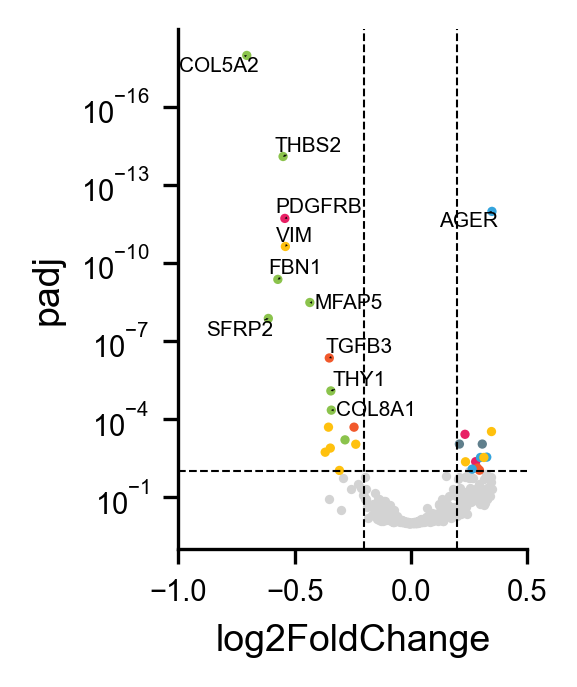

In [40]:
fig, ax = plt.subplots(1, 1, figsize=(1.5, 2.25))

significant = (
    ~data[x].between(-logfc_min, logfc_min) &
    data[y].lt(pval_min)
)

# Scatters
sns.scatterplot(
    data=data[~significant], x=x, y=y,
    palette=named_colors,
    s=5,
    lw=0,
    legend=False,
    color='lightgray',
)
sns.scatterplot(
    data=data[significant], x=x, y=y, hue=hue,
    palette=named_colors,
    s=5,
    lw=0,
    legend=False,
)

# Vlines
styles = dict(lw=0.5, linestyle='--', color='k')
h1 = ax.axhline(pval_min, **styles)
v1 = ax.axvline(-logfc_min, **styles)
v2 = ax.axvline(logfc_min, **styles)
objects = [h1, v1, v2]

# Named genes
texts = []
for gene in named_genes:
    if gene in summary[significant].index:
        row = summary.loc[gene]
        styles = dict(ha='center', va='center', size=5)
        t = ax.text(row[x], row[y], gene, **styles)
        texts.append(t)

# Formatting
ax.set_ylim(1e1, data[y].min() * 0.1)
ax.set_yscale('log')
ax.set_xlim(-1, 0.5)

adjust_text(
    texts,
    objects=objects,
    force_text=(0.25, 0.5),
    force_explode=(0.125, 0.25),
    min_arrow_len=0,
    expand=(1.1, 1.1),
    arrowprops={'color':'k', 'lw':0.05, 'shrinkB':1, 'shrinkA':1}
)

fig.savefig(media_dir / 'segger_10x_de.svg')

### 10X vs. CellPose

In [50]:
# Join
counts = pd.concat([counts_10x, counts_cp])
metadata = pd.DataFrame(
    ['10X'] * counts_10x.shape[0] + ['Cellpose'] * counts_cp.shape[0],
    index=counts.index,
    columns=['Segmentation']
)

In [51]:
with HiddenPrints():
    inference = DefaultInference(n_cpus=32)
    dds = DeseqDataSet(
        counts=counts,
        metadata=metadata,
        design_factors="Segmentation",
        refit_cooks=True,
        inference=inference, # n_cpus can be specified here or in the inference object
        quiet=True,
    )
    dds.deseq2()
    stat_res = DeseqStats(dds)
    stat_res.summary()
    summary = stat_res.results_df

Fitting dispersions...
... done in 0.01 seconds.

Fitting MAP dispersions...
... done in 0.01 seconds.

Fitting LFCs...
... done in 0.01 seconds.

Running Wald tests...
... done in 11.31 seconds.



In [52]:
summary = stat_res.results_df
summary['label'] = coefs.idxmax(1)
summary['label'] = summary['label'].fillna('Unassigned')
data = summary

x = 'log2FoldChange'
y = 'padj'
hue = 'label'

logfc_min = 0.1
pval_min = 0.05
named_genes = data.index[~data[x].between(-0.1, 0.1) & data[y].lt(0.05)]

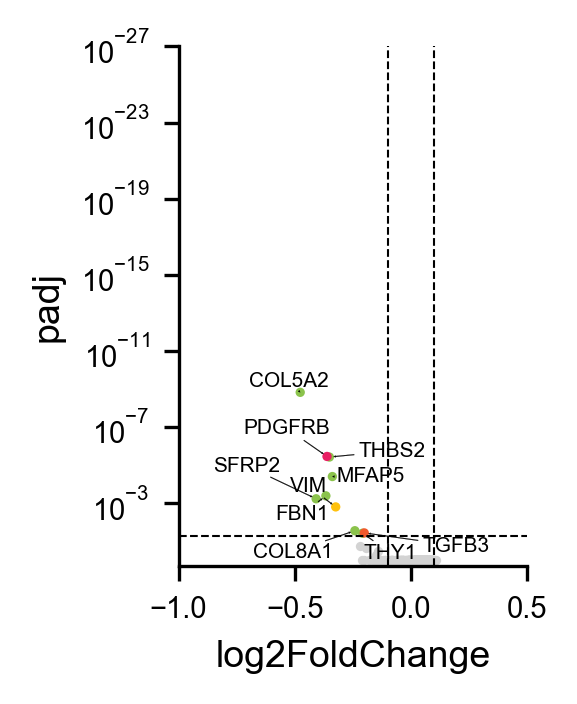

In [53]:
fig, ax = plt.subplots(1, 1, figsize=(1.5, 2.25))

significant = (
    ~data[x].between(-logfc_min, logfc_min) &
    data[y].lt(pval_min)
)

# Scatters
sns.scatterplot(
    data=data[~significant], x=x, y=y,
    palette=named_colors,
    s=5,
    lw=0,
    legend=False,
    color='lightgray',
)
sns.scatterplot(
    data=data[significant], x=x, y=y, hue=hue,
    palette=named_colors,
    s=5,
    lw=0,
    legend=False,
)

# Vlines
styles = dict(lw=0.5, linestyle='--', color='k')
h1 = ax.axhline(pval_min, **styles)
v1 = ax.axvline(-logfc_min, **styles)
v2 = ax.axvline(logfc_min, **styles)
objects = [h1, v1, v2]

# Named genes
texts = []
for gene in named_genes:
    if gene in summary[significant].index:
        row = summary.loc[gene]
        styles = dict(ha='center', va='center', size=5)
        t = ax.text(row[x], row[y], gene, **styles)
        texts.append(t)

# Formatting
ax.set_ylim(2e0, 1e-27)
ax.set_yscale('log')
ax.set_xlim(-1, 0.5)

adjust_text(
    texts,
    objects=objects,
    force_text=(0.25, 0.5),
    force_explode=(0.125, 0.25),
    min_arrow_len=0,
    expand=(1.1, 1.1),
    arrowprops={'color':'k', 'lw':0.05, 'shrinkB':1, 'shrinkA':1}
)

fig.savefig(media_dir / 'cellpose_10x_de.svg')

### Segger vs. Cellpose

In [54]:
# Join
counts = pd.concat([counts_seg, counts_cp])
metadata = pd.DataFrame(
    ['Segger'] * counts_seg.shape[0] + ['Cellpose'] * counts_cp.shape[0],
    index=counts.index,
    columns=['Segmentation']
)

In [55]:
with HiddenPrints():
    inference = DefaultInference(n_cpus=32)
    dds = DeseqDataSet(
        counts=counts,
        metadata=metadata,
        design_factors="Segmentation",
        refit_cooks=True,
        inference=inference, # n_cpus can be specified here or in the inference object
        quiet=True,
    )
    dds.deseq2()
    stat_res = DeseqStats(dds)
    stat_res.summary()
    summary = stat_res.results_df

Fitting dispersions...
... done in 0.01 seconds.

Fitting MAP dispersions...
... done in 0.01 seconds.

Fitting LFCs...
... done in 0.01 seconds.

Running Wald tests...
... done in 10.62 seconds.



In [56]:
summary['log2FoldChange'] *= -1

In [57]:
summary = stat_res.results_df
summary['label'] = coefs.idxmax(1)
summary['label'] = summary['label'].fillna('Unassigned')
data = summary

x = 'log2FoldChange'
y = 'padj'
hue = 'label'

logfc_min = 0.1
pval_min = 0.05
named_genes = data.index[~data[x].between(-0.1, 0.1) & data[y].lt(0.05)]

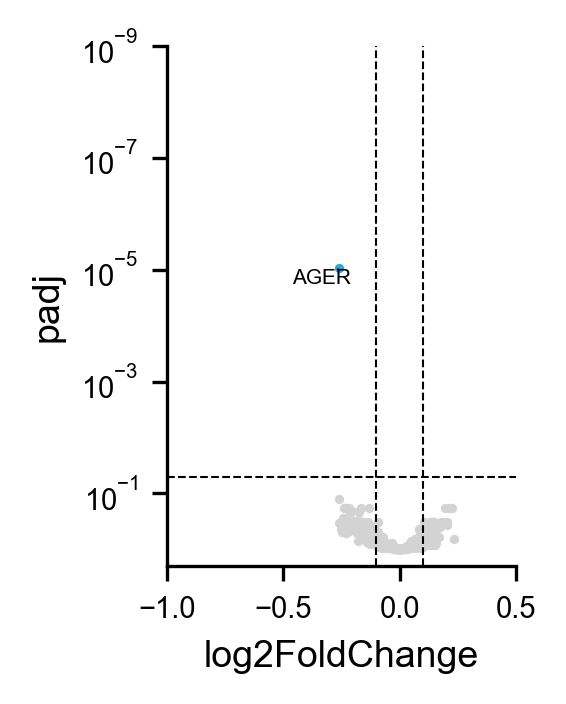

In [58]:
fig, ax = plt.subplots(1, 1, figsize=(1.5, 2.25))

significant = (
    ~data[x].between(-logfc_min, logfc_min) &
    data[y].lt(pval_min)
)

# Scatters
sns.scatterplot(
    data=data[~significant], x=x, y=y,
    palette=named_colors,
    s=5,
    lw=0,
    legend=False,
    color='lightgray',
)
sns.scatterplot(
    data=data[significant], x=x, y=y, hue=hue,
    palette=named_colors,
    s=5,
    lw=0,
    legend=False,
)

# Vlines
styles = dict(lw=0.5, linestyle='--', color='k')
h1 = ax.axhline(pval_min, **styles)
v1 = ax.axvline(-logfc_min, **styles)
v2 = ax.axvline(logfc_min, **styles)
objects = [h1, v1, v2]

# Named genes
texts = []
for gene in named_genes:
    if gene in summary[significant].index:
        row = summary.loc[gene]
        styles = dict(ha='center', va='center', size=5)
        t = ax.text(row[x], row[y], gene, **styles)
        texts.append(t)

# Formatting
ax.set_ylim(2e0, 1e-9)
ax.set_yscale('log')
ax.set_xlim(-1, 0.5)

adjust_text(
    texts,
    objects=objects,
    force_text=(0.25, 0.5),
    force_explode=(0.125, 0.25),
    min_arrow_len=0,
    expand=(1.1, 1.1),
    arrowprops={'color':'k', 'lw':0.05, 'shrinkB':1, 'shrinkA':1}
)

fig.savefig(media_dir / 'cellpose_seg_de.svg')

## Filtered nuclear contaminants